In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

N = 256
M = 512

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u[i,j] * 4.0
    force = laplacian - 0.1 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input([-1, -1], tf.float32)

    u,v = WaveIteration(u, v, 0.2)

    return [u, v]

test = tf.program(WaveEq)


TensorFrost module loaded!
TensorProgram:
  Kernel count: 3
  Intermediate buffers: 7
  Lines of generated code: 149
  IR size: 273



In [2]:
test.list_operations()

List of operations:

[] int m0 = memory()
[] int m1 = memory()

[m0,m1] float m2 = memory(memory_type=input, )
[] int m3 = memory()
[] int m4 = memory()

[m3,m4] float m5 = memory(memory_type=input, )

[m0,m1] float m6 = memory()

[m0,m1] int v5_0 = dim_id(data=[0], )
[m0,m1] int v5_1 = dim_id(data=[1], )
[m0,m1] int v5_3 = sub(inputs=[v5_0,1], cost=1.000000)
[m0,m1] int v5_5 = add(inputs=[v5_0,1], cost=1.000000)
[] int v5_7 = sub(inputs=[m0,1], cost=1.000000)
[m0,m1] int v5_9 = clamp(inputs=[v5_3,0,v5_7], cost=6.000000)
[m0,m1] int v5_10 = mul(inputs=[v5_9,m1], cost=7.000000)
[] int v5_12 = sub(inputs=[m1,1], cost=1.000000)
[m0,m1] int v5_14 = clamp(inputs=[v5_1,0,v5_12], cost=5.000000)
[m0,m1] int v5_15 = add(inputs=[v5_10,v5_14], cost=13.000000)
[m0,m1] float v5_16 = load(memory=[m2], indices=[v5_15], cost=141.000000)
[] int v5_18 = sub(inputs=[m0,1], cost=1.000000)
[m0,m1] int v5_20 = clamp(inputs=[v5_5,0,v5_18], cost=6.000000)
[m0,m1] int v5_21 = mul(inputs=[v5_20,m1], cost=7.0000

In [3]:
#do a few steps and measure performance by timing every 100 steps
import time
import imageio
from IPython.display import Image
import os

start = time.time()

file_path = 'H:/TestVideos/wave.gif'

#remove file if it exists

if os.path.isfile(file_path):
    os.remove(file_path)

writer = imageio.get_writer(file_path, mode='I', fps=30, loop=0)

x = np.arange(M)
y = np.arange(N)
X,Y = np.meshgrid(x, y)
Anp = np.exp(-((X-M/2)**2 + (Y-N/2+50)**2)/(10**2))
Anp += np.exp(-((X-M/2-50)**2 + (Y-N/2-50)**2)/(10**2))
Bnp = np.zeros((N, M))

A = tf.memory(Anp)
B = tf.memory(Bnp)

print("Used memory: " + str(tf.used_memory()))

iters = 1000

for i in range(iters):
    A, B = test(A, B)
    if(i % 50 == 0):
        frame = A.numpy
        frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
        writer.append_data(frame)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


writer.close()

print("Used memory: " + str(tf.used_memory()))

Used memory: 262144
Iterations per second: 1052.6365454741665
Iterations per second: 4347.915867602393
Iterations per second: 4761.871459225032
Iterations per second: 4347.870796533565
Iterations per second: 4999.945164328204
Iterations per second: 3703.743211620822
Iterations per second: 4166.6789187685645
Iterations per second: 4761.817397425127
Iterations per second: 4347.915867602393
Iterations per second: 4000.022888314562
Used memory: 393220


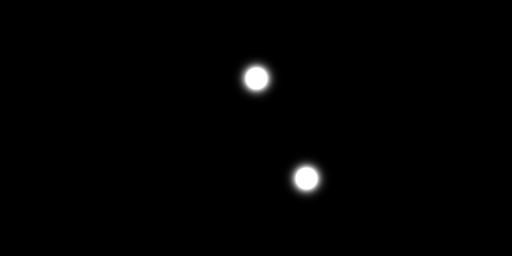

In [4]:
#display the gif
Image(filename=file_path)

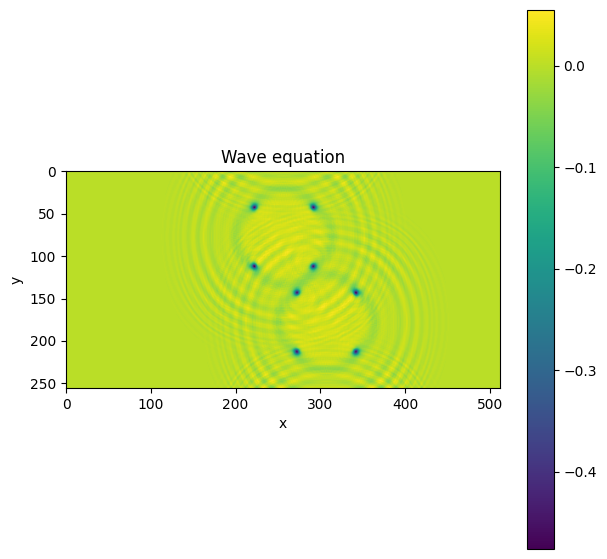

In [5]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()